In [5]:
from lib.ekyn import get_ekyn_ids,load_ekyn_pt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,ConcatDataset
import math
from torch import nn
from lib.models import RegNet
from torch.nn.functional import relu
import matplotlib.pyplot as plt
import torch
from lib.datasets import EpochedDataset,SequencedDataset
from tqdm import tqdm
import numpy as np
import random

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

CONFIG = {
    'WINDOW_SIZE':5000,
    'BATCH_SIZE':512,
    'LEARNING_RATE':3e-4,
    'DEVICE':'cuda',
    'SEQUENCE_LENGTH':3
}

train_idx,test_idx = train_test_split(get_ekyn_ids(),test_size=.25,random_state=0)

In [6]:
trainloader = DataLoader(ConcatDataset([SequencedDataset(idx=idx,condition=condition,sequence_length=3) for idx in train_idx for condition in ['Vehicle','PF']]),batch_size=512,shuffle=True)
devloader = DataLoader(ConcatDataset([SequencedDataset(idx=idx,condition=condition,sequence_length=3) for idx in test_idx for condition in ['Vehicle','PF']]),batch_size=512,shuffle=True)

In [8]:
from lib.models import Dumbledore
model = Dumbledore(encoder_path=f'projects/0',sequence_length=3)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([18.3846,  2.2810,  1.9716]))
optimizer = torch.optim.Adam(model.parameters(),lr=CONFIG['LEARNING_RATE'])
model.to(CONFIG['DEVICE']);

Model is freezing encoder


In [11]:
criterion.to(CONFIG['DEVICE'])

CrossEntropyLoss()

In [12]:
lossi = []

In [13]:

for i in tqdm(range(10)):
    for Xi,yi in trainloader:
        Xi,yi = Xi.to(CONFIG['DEVICE']),yi.to(CONFIG['DEVICE'])
        logits = model(Xi)
        loss = criterion(logits,yi)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
loss

100%|██████████| 10/10 [01:24<00:00,  8.48s/it]


tensor(0.9138, device='cuda:0', grad_fn=<DivBackward1>)

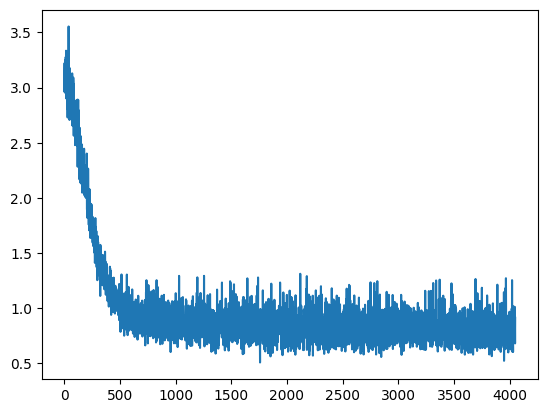

In [14]:
plt.plot(lossi)

100%|██████████| 135/135 [00:02<00:00, 45.05it/s]


              precision    recall  f1-score   support

         0.0       0.45      0.54      0.49      3504
         1.0       0.93      0.95      0.94     31617
         2.0       0.91      0.89      0.90     33999

    accuracy                           0.90     69120
   macro avg       0.77      0.79      0.78     69120
weighted avg       0.90      0.90      0.90     69120

1.7564966713940655


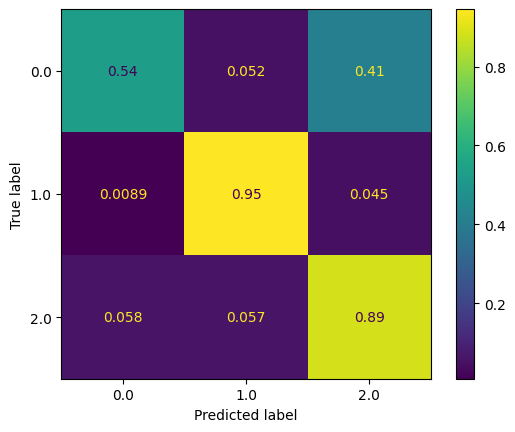

In [16]:
from lib.utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

loss,report,y_true,y_pred,y_logits = evaluate(dataloader=devloader,model=model,criterion=criterion,DEVICE=CONFIG['DEVICE'])
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)